In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.metrics import accuracy_score , confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score,f1_score , precision_recall_curve, roc_curve, auc
from sklearn.impute import SimpleImputer
from scipy.spatial.distance import euclidean
from itertools import combinations
import random
import matplotlib.pyplot as plt
from sklearn.calibration import label_binarize
import seaborn as sn

In [2]:
def load_signature_data(file_path):
    # Définir les noms de colonnes
    column_names = ['x', 'y', 'timestamp', 'button', 'azimuth', 'altitude', 'pressure']
    
    # Charger le fichier CSV dans un DataFrame Pandas en utilisant les noms de colonnes
    df = pd.read_csv(file_path, sep=' ', index_col=False, names=column_names)

    # Supprimer la première ligne qui contient le nombre de lignes
    df = df.iloc[1:]

    # Réinitialiser les index du DataFrame
    df = df.reset_index(drop=True)
    
    return df 

In [3]:
def CalculeFeature(df):
    epsilon = 1e-8 
    # Calculer la différence de coordonnées à chaque instant
    delta_x = df['x'].diff()
    delta_y = df['y'].diff()

    # Calculer la norme de la vitesse à chaque instant
    delta_t = df['timestamp'].diff() + epsilon
    vitesse = np.sqrt(delta_x**2 + delta_y**2) / delta_t

    # Calculer la norme de l'accélération à chaque instant
    acceleration = vitesse.diff() / delta_t
    df['acceleration'] = acceleration 

    # Calculer l'inclinaison du stylo
    pen_incl = np.arctan2(df['altitude'], df['azimuth'])
    df['pen_incl'] = pen_incl 
      
    # Calculer les dérivées secondes des coordonnées à chaque point

    dx = np.gradient(df['x'])
    dy = np.gradient(df['y'])

    d2x = np.gradient(dx)
    d2y = np.gradient(dy)

    denominator = np.power(dx*dx + dy*dy, 1.5) + epsilon
    curvature = np.abs(d2x*dy - dx*d2y) / denominator
    
    df['curvature'] = curvature
    if df.isnull().any().any():
        df = df.fillna(df.mean())
        
    return df  


In [4]:
# def selectFeatures(df):
#     nouvelledf = df[['x', 'y', 'timestamp', 'pen_incl', 'curvature', 'acceleration']]
#     return nouvelledf

def selectFeatures(df):
    nouvelledf = df[['x', 'y', 'timestamp','azimuth','altitude','pressure','pen_incl']]
    return nouvelledf


In [5]:
def DonnerClasse(directory):
    # Initialiser une liste pour stocker les DataFrames de chaque utilisateur
    dfs = []

    # Parcourir tous les fichiers du répertoire
    for filename in os.listdir(directory):
        if filename.endswith('.TXT'):
            # Joindre le chemin du fichier avec le répertoire de travail actuel
            file_path = os.path.join(directory, filename)

            df = selectFeatures(CalculeFeature(load_signature_data(file_path)))
            #df = CalculeFeature(load_signature_data(file_path))
            
            user_id, signature_id = filename.split('S')
            user_id = int(user_id[1:])
            signature_id = int(signature_id[:-4]) 

            df['classe'] = user_id
        
            # Ajouter le DataFrame à la liste
            dfs.append(df)
    
    # Concaténer tous les DataFrames en un seul DataFrame
    result = pd.concat(dfs, axis=0, ignore_index=True)

    return result  

In [6]:
def KNN(data):
    # Séparer les données en ensembles d'entraînement et de test
    # X = data[['x', 'y', 'timestamp', 'pen_incl', 'curvature', 'acceleration']]
    # X = data[['x', 'y', 'button','altitude','pressure','pen_incl', 'curvature']]
    X = selectFeatures(data)
    y = data['classe']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

    # Remplacer les valeurs infinies ou trop grandes par NaN
    X_train[~np.isfinite(X_train)] = 0
    X_test[~np.isfinite(X_test)] = 0

    # Imputer les valeurs manquantes par la moyenne de chaque colonne
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Appliquer l'algorithme KNN avec k=5
    k = 1
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Prédire les classes pour les données de test
    y_pred = knn.predict(X_test)

    # Calculerl'accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print('knn Accuracy:', accuracy)

    return knn 

In [7]:
def training(directory):
    data = DonnerClasse(directory) 
    knn=KNN(data) 
    return knn

In [8]:
def compare_signatures(knn,signature_path1, signature_path2):
  
    signature1 = selectFeatures(CalculeFeature(load_signature_data(signature_path1)))
    signature2 = selectFeatures(CalculeFeature(load_signature_data(signature_path2)))
   
    minN = min(len(signature1), len(signature2))
    
    y1=knn.predict(signature1.iloc[:minN,:])
    y2=knn.predict(signature2.iloc[:minN,:]) 
    # print("y1",y1)
    # print("y2",y2)
    accuracy = accuracy_score(y1, y2)   
    
    if accuracy>0.50 : 
        similarity = True
    else :
        similarity = False
    return accuracy , similarity 


In [9]:
# Définir le répertoire contenant les fichiers texte
directory = './data/Task1/'
data = DonnerClasse(directory)
data.head()

,x,y,timestamp,azimuth,altitude,pressure,pen_incl,classe
0,3236,5028.0,17638839.0,1260.0,400.0,351.0,0.307397,10
1,3428,4998.0,17638849.0,1260.0,400.0,382.0,0.307397,10
2,3541,5056.0,17638859.0,1260.0,400.0,394.0,0.307397,10
3,3665,5135.0,17638869.0,1310.0,400.0,397.0,0.296352,10
4,3945,5229.0,17638879.0,1370.0,390.0,405.0,0.277335,10


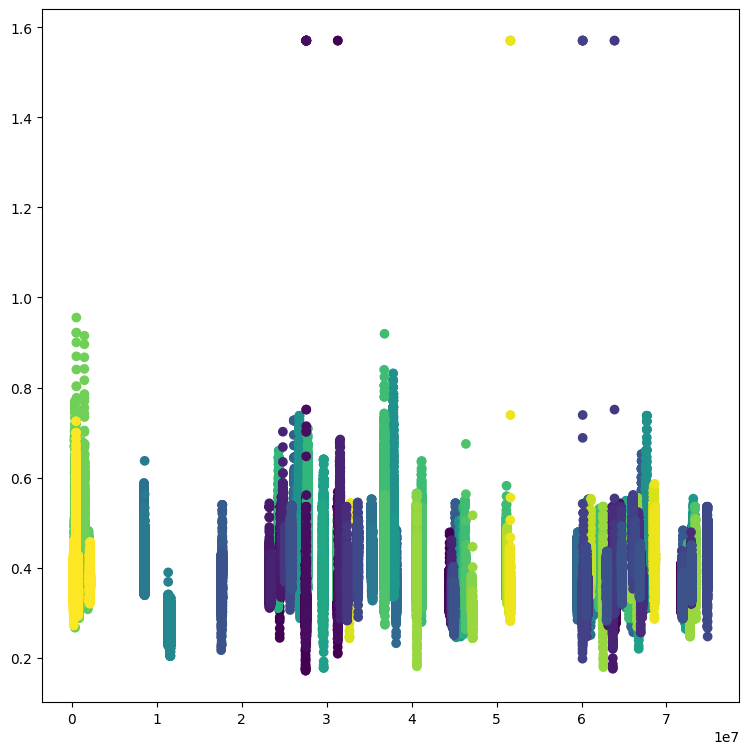

In [14]:
plt.figure(figsize=(9,9))
plt.scatter(data["timestamp"], data["pen_incl"], c=data["classe"])

In [ ]:
%matplotlib    
from mpl_toolkits.mplot3d import Axes3D
     

ax = plt.axes(projection='3d')
ax.scatter(data["x"], data["y"], data["timestamp"], c=data["classe"])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Using matplotlib backend: <object object at 0x000002777F99FB00>


In [ ]:
sn.pairplot(data, hue='classe')

In [ ]:
data.corr()

In [ ]:
sn.heatmap(data.corr())

In [10]:
# Définir le répertoire contenant les fichiers texte
directory = './data/Task1/'
knn = training(directory)

knn Accuracy: 0.9999121081948121


In [ ]:
acc,sm=compare_signatures(knn,"./data/Test/U13S5.TXT", "./data/Test/U14S14.TXT")
print("acc : ",acc)
print("sm : ",sm)

y1 [13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13]
y2 [14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14
 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 14 1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


In [29]:
test_folder_path = './data/Test/'
train_folder_path = './data/Task1/'
train_files = os.listdir(train_folder_path)

files_paths = [os.path.join(test_folder_path, filename) for filename in os.listdir(test_folder_path)]

j=1
for i in range(1, 34,2):
    file_name = f"U{i}S{j}.TXT"
    if file_name in train_files:
        files_paths.append(os.path.join(train_folder_path, file_name))

    j+=1
    
random_files_paths = random.sample(files_paths, 20)

In [30]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

file_info = [{'file_name': os.path.basename(file_path), 'file_path': file_path} for file_path in random_files_paths]

file_combinations = combinations(file_info, 2)
results = []

results_df = pd.DataFrame(columns=['File 1', 'File 2', 'Similarity'])

for file_pair in file_combinations:
    file1, file2 = file_pair
    acc, sm = compare_signatures(knn, file1['file_path'], file2['file_path'])
    if sm :
        label=0
    else:
        label=1
    results.append({'File 1': file1['file_name'], 'File 2': file2['file_name'], 'Similarity': label})

results_df = pd.concat([results_df, pd.DataFrame(results)], ignore_index=True)
results_df.to_csv('Signature_Similarity.csv', index=False)

In [11]:
X = selectFeatures(data)
y = data['classe']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

X_train[~np.isfinite(X_train)] = 0
X_test[~np.isfinite(X_test)] = 0

imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

k = 1
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

Precision: 0.999949708562181
Recall: 0.999923622705474
F1-score: 0.9999366291054038

Confusion Matrix:
 [[1506    0    0 ...    0    0    0]
 [   0 1913    0 ...    0    0    0]
 [   0    0 1721 ...    0    0    0]
 ...
 [   0    0    0 ... 2121    0    0]
 [   0    0    0 ...    0 2382    0]
 [   0    0    0 ...    0    0 2134]]


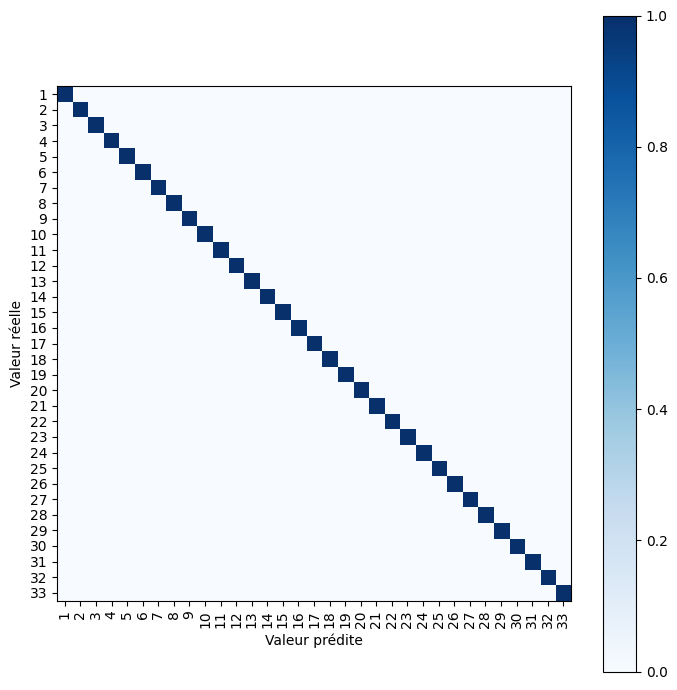

In [12]:
# Calculer la précision, le rappel et le F1-score
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
    
############################### Matrice de confusion ###########################################################
    
# Calculer la matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Normaliser la matrice de confusion
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Afficher la matrice de confusion
#np.set_printoptions(threshold=np.inf)
print("\nConfusion Matrix:\n", cm)
   
   
plt.figure(figsize=(7, 7))
plt.imshow(cm_norm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_pred), rotation=90)
plt.yticks(tick_marks, np.unique(y_test))
plt.tight_layout()
plt.xlabel('Valeur prédite')
plt.ylabel('Valeur réelle')
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


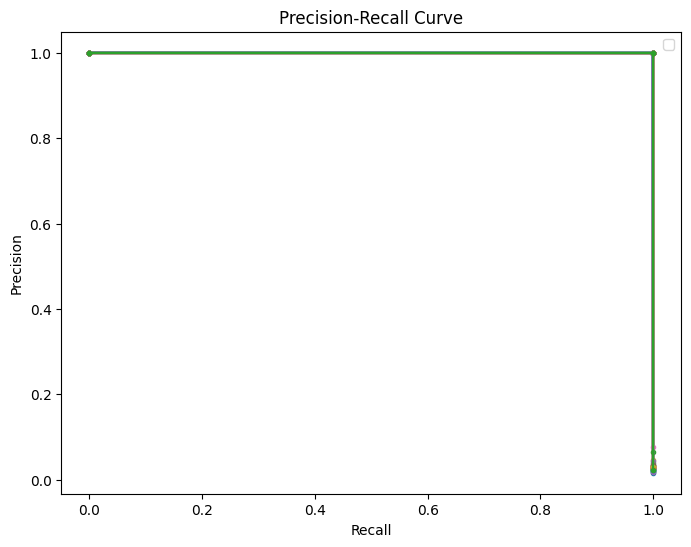

In [13]:
# Convert the multiclass labels into binary labels
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Calculate probabilities for each class using predict_proba
y_scores = knn.predict_proba(X_test)

# Compute the precision and recall for each class
precision_curve = dict()
recall_curve = dict()
for i in range(len(np.unique(y_test))):
    precision_curve[i], recall_curve[i], _ = precision_recall_curve(y_test_bin[:, i], y_scores[:, i])

# Plot the precision-recall curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    # plt.plot(recall_curve[i], precision_curve[i], marker='.', label=f'Class {i}')
    plt.plot(recall_curve[i], precision_curve[i], marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


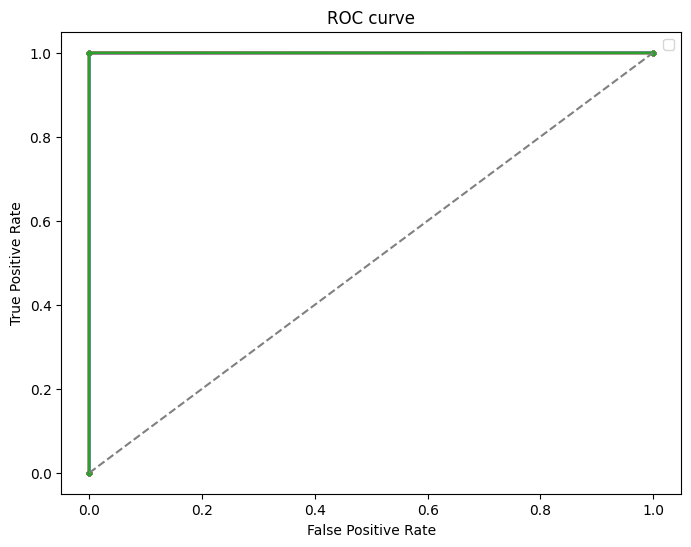

In [14]:
# Compute the false positive rate, true positive rate, and area under the ROC curve for each class
fpr = dict()
tpr = dict()
# roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_scores[:, i])
    # roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curves for each class
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    # plt.plot(fpr[i], tpr[i], marker='.', label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
        plt.plot(fpr[i], tpr[i], marker='.')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
# plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend()
plt.show()

In [15]:
cv_scores = cross_val_score(knn, X_train, y_train, cv=5)

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))

Cross-Validation Scores: [0.99989177 0.99989177 0.99989177 0.99994589 0.9998106 ]
Mean CV Score: 0.9998863623186522
